In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
from sklearn.naive_bayes import MultinomialNB
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,confusion_matrix, roc_curve, roc_auc_score
import joblib
import seaborn as sns

<h3> Data Loading

In [3]:
df = pd.read_csv("Tweets.csv")

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Data Exploration

In [4]:
df.shape

(14640, 15)

In [5]:
df.isna().sum() #checks for rows with empty values

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [6]:
new = df.drop(['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence',
               'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'airline', 'tweet_coord', 
               'tweet_created', 'tweet_location', 'user_timezone'], axis=1)


In [7]:
new.isna().sum()

airline_sentiment    0
text                 0
dtype: int64

In [8]:
new.airline_sentiment.value_counts() # accounts for the total number of each sentiment in the dataset

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

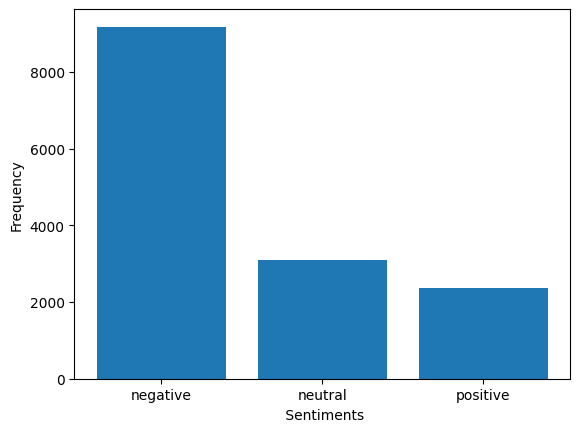

In [9]:
sent = new['airline_sentiment'].value_counts()

plt.bar(sent.index, sent.values)
plt.xlabel(" Sentiments")
plt.ylabel("Frequency")
plt.show()

<h3> Data Preprocessing

- Loading large spacy english pretrained pipeline which will be used for the text preproceesing 

In [10]:
nlp=spacy.load("en_core_web_lg")

- define a function to remove stopwords and punctuatons, also tokenizing , lowercase conversion and lemmitizing the words.

In [11]:
def preprocess_text(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_.lower())

    return " ".join(filtered_tokens)


In [12]:
new['preprocessed_tweet'] = new.text.apply(preprocess_text) #tweets preprocessing

In [13]:
new.head(10)

,airline_sentiment,text,preprocessed_tweet
0,neutral,@VirginAmerica What @dhepburn said.,say
1,positive,@VirginAmerica plus you've added commercials t...,plus add commercial experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I n...,today mean need trip
3,negative,@VirginAmerica it's really aggressive to blast...,aggressive blast obnoxious entertainment gue...
4,negative,@VirginAmerica and it's a really big bad thing...,big bad thing
5,negative,@VirginAmerica seriously would pay $30 a fligh...,seriously pay $ 30 flight seat playing \n ba...
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",yes nearly time fly vx ear worm will away
7,neutral,@VirginAmerica Really missed a prime opportuni...,miss prime opportunity man hats parody
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D",didn't :-d
9,positive,"@VirginAmerica it was amazing, and arrived an ...",amazing arrive hour early good


<h3> Handling Class Imbalance </h3> <br>
Since there is imbalance in the labels, Oversampling method will be used to balance the dataset which involves populating the minority labels to be equal to the majority label.

In [14]:
# class count
count_class_negative, count_class_neutral, count_class_positive = new.airline_sentiment.value_counts()
count_class_negative, count_class_neutral, count_class_positive

(9178, 3099, 2363)

In [15]:
df_class_negative = new[new['airline_sentiment']=="negative"]
df_class_neutral = new[new['airline_sentiment']== "neutral"]
df_class_positive = new[new['airline_sentiment']== "positive"]

In [16]:
df_class_neutral_over = df_class_neutral.sample(count_class_negative, replace=True)
df_class_positive_over = df_class_positive.sample(count_class_negative, replace=True)

df_test_over = pd.concat([df_class_negative,df_class_neutral_over,df_class_positive_over], axis=0)

print(df_test_over.airline_sentiment.value_counts())

airline_sentiment
negative    9178
neutral     9178
positive    9178
Name: count, dtype: int64


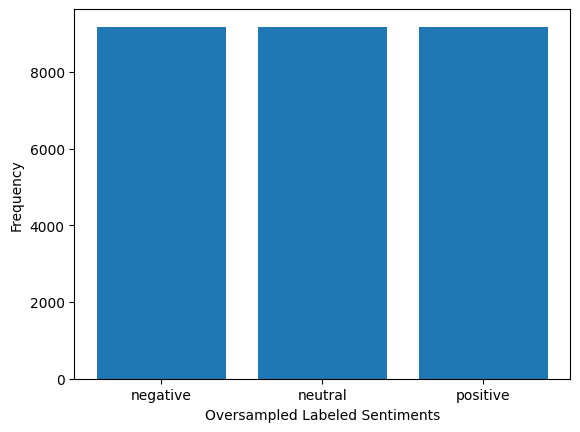

In [17]:
classes_instances = df_test_over['airline_sentiment'].value_counts()


plt.bar(classes_instances.index, classes_instances.values)
plt.xlabel("Oversampled Labeled Sentiments")
plt.ylabel("Frequency")
plt.show()

In [18]:
encode = LabelEncoder()

df_test_over['new_label'] = encode.fit_transform(df_test_over.airline_sentiment)

In [19]:
df_test_over.new_label.value_counts()

new_label
0    9178
1    9178
2    9178
Name: count, dtype: int64

0: negative, 1: neutral, 2: positive

<h3>Feature Extraction and Model Training.</h3> <br>
 TD-IDF Feature extraction technique will be applied to convert the preprocessed text into numerical feature (matrix form) and then the model is created using a pipeline approach.

In [21]:
# split the balanced dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(df_test_over['preprocessed_tweet'],
                                    df_test_over['new_label'],
                                    test_size=0.2,
                                    random_state=100)

In [35]:
print('Traning Size:', x_train.shape [0] + y_train.shape [0])
print ('Testing Size:', x_test.shape [0] + y_test.shape [0])

Traning Size: 44054
Testing Size: 11014


In [23]:
clf = Pipeline([
    ("tf", TfidfVectorizer()),
    ('munb', MultinomialNB(alpha=0.001))
])
clf.fit(x_train, y_train)

Pipeline(steps=[('tf', TfidfVectorizer()),
                ('munb', MultinomialNB(alpha=0.001))])

In [24]:
print(classification_report(y_test, clf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1855
           1       0.82      0.81      0.81      1839
           2       0.86      0.90      0.88      1813

    accuracy                           0.84      5507
   macro avg       0.84      0.84      0.84      5507
weighted avg       0.84      0.84      0.84      5507



In [25]:
y_pred = clf.predict(x_test)

f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy score: ", accuracy.__round__(2))
print("F1 score:", f1.__round__(2))
print("Precision score:", precision.__round__(2))
print("Recall score:", recall.__round__(2))


Accuracy score:  0.84
F1 score: 0.84
Precision score: 0.84
Recall score: 0.84


- Confusion Matrix, AUC_ROC Curve

In [26]:
# Confusion Matrix for model 1
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1512  225  118]
 [ 200 1482  157]
 [  75  109 1629]]


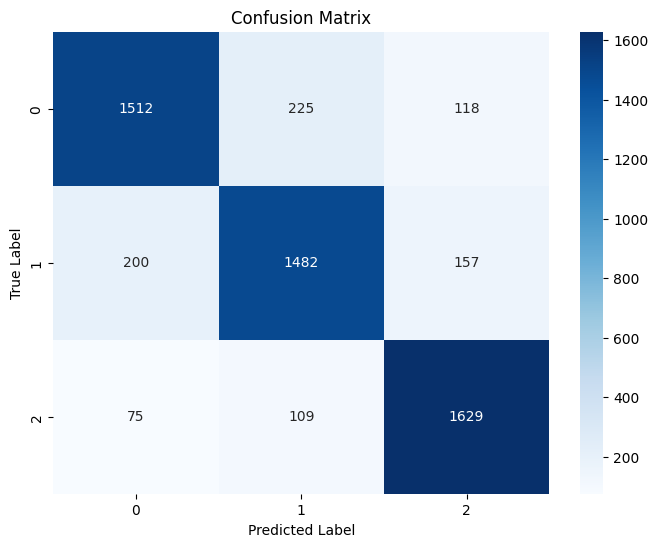

In [27]:
# Plot Confusion Matrix for model 1
label = LabelEncoder()
label.fit(y_train)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label.classes_, yticklabels=label.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [28]:
y_scores = clf.predict_proba(x_test)

# the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_scores[:, i])
    roc_auc[i] = roc_auc_score(y_test == i, y_scores[:, i])

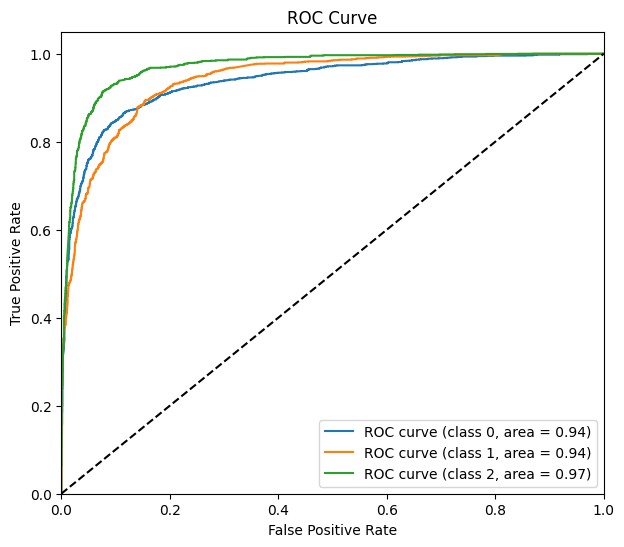

In [29]:
plt.figure(figsize=(7, 6))
for i in range(len(label.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}, area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [30]:
joblib.dump(clf, "Munb_classifier.joblib")

['Munb_classifier.joblib']